In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

In [2]:
from nsepython import equity_history
series = "EQ"
start_date = "01-12-2003"
end_date ="01-11-2023"
symbol = "BOSCHLTD"

data=equity_history(symbol,series,start_date,end_date)
columns = ['CH_OPENING_PRICE', 'CH_TRADE_HIGH_PRICE', 'CH_TRADE_LOW_PRICE', 'CH_CLOSING_PRICE', 'CH_TIMESTAMP', 'CH_TOT_TRADED_QTY']
data = data[columns]

# Rename columns for consistency with ta library
data = data.rename(columns={
    'CH_TIMESTAMP': 'Date',
    'CH_OPENING_PRICE': 'Open',
    'CH_TRADE_HIGH_PRICE': 'High',
    'CH_TRADE_LOW_PRICE': 'Low',
    'CH_CLOSING_PRICE': 'Close',
    'CH_TOT_TRADED_QTY': 'Volume'
})


/home/siddique/.local/lib/python3.10/site-packages/nsepython/rahu.py:582: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total = pd.concat([total, equity_history_virgin(symbol, series, start_date, temp_date)])


In [103]:
# Sort DataFrame by date
data = data.sort_values('Date')
data = data.rename(columns={'volume':'Volume'})
# Double check the result
df = data.reset_index(drop=True)
df

,Open,High,Low,Close,Date,Volume
0,12400.00,12549.80,12250.0,12549.80,2003-12-01,2062
1,13000.00,13177.10,12801.0,13147.35,2003-12-02,1509
2,13180.00,13804.75,13000.0,13752.95,2003-12-03,914
3,13900.00,14420.00,13066.0,13579.35,2003-12-04,901
4,13799.00,13998.00,13000.0,13188.65,2003-12-05,454
...,...,...,...,...,...,...
5078,19503.05,19816.20,19480.0,19648.35,2023-10-26,23748
5079,19739.00,19964.80,19709.7,19742.65,2023-10-27,23336
5080,19742.65,19927.20,19400.0,19478.10,2023-10-30,17238
5081,19566.60,19608.85,19362.5,19450.95,2023-10-31,8370


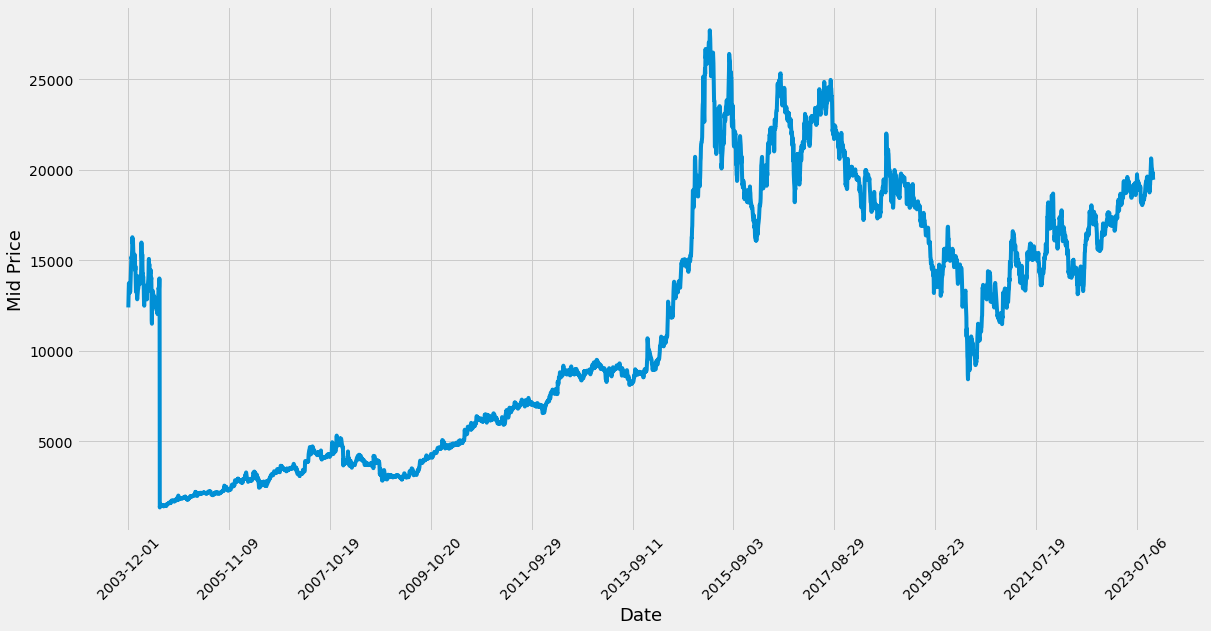

In [92]:
plt.figure(figsize = (18,9))
mid_price = (df['Low'] + df['High']) / 2.0
plt.plot(mid_price)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# ***Step 1:Training***

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [119]:
new_training_set = df.iloc[:, 3:4]
dates = df.iloc[:, 4:5]
dates = np.array(dates)
new_training_set = np.array(new_training_set)
new_training_set

array([[12549.8 ],
       [13147.35],
       [13752.95],
       ...,
       [19478.1 ],
       [19450.95],
       [19358.4 ]])

In [124]:
# FEATURE SCALING 
sc = MinMaxScaler()
new_training_set = sc.fit_transform(new_training_set)

# CREATING INPUT DATA STREAM
x_train = new_training_set[:]
x_new_train=[]
y_train=[]
for i in range(0,4000):
    x_new_train.append([x_train[i:i+50]])
    y_train.append(x_train[i+50])

training_dates = dates[:4000]
x_train = np.reshape(x_new_train,(4000,50,1))
y_train = np.array(y_train)


# BUILDING THE MODEL
model = Sequential()

model.add(LSTM(1000,input_shape=(50,1),return_sequences=True))
model.add(LSTM(500))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dense(1))

In [125]:
# COMPILING MODEL 
model.compile(optimizer="adam",loss="mean_squared_error")

In [126]:
# STRUCTURE OF THE MODEL
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 1000)          4008000   
                                                                 
 lstm_9 (LSTM)               (None, 500)               3002000   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               64128     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7074257 (26.99 MB)
Trainable params: 7074257 (26.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
# TRAINING THE MODEL ON THE TRAINING SET
model.fit(x_train,y_train,batch_size=256,epochs=100)

Epoch 1/100


2023-12-10 22:27:11.663810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51200000 exceeds 10% of free system memory.
2023-12-10 22:27:11.759762: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51200000 exceeds 10% of free system memory.
2023-12-10 22:27:12.006314: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51200000 exceeds 10% of free system memory.
2023-12-10 22:27:15.627483: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51200000 exceeds 10% of free system memory.
2023-12-10 22:27:15.702818: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51200000 exceeds 10% of free system memory.


16/16 [==============================] - 70s 4s/step - loss: 0.0550
Epoch 2/100
16/16 [==============================] - 54s 3s/step - loss: 0.0039
Epoch 3/100
16/16 [==============================] - 54s 3s/step - loss: 0.0011
Epoch 4/100
16/16 [==============================] - 53s 3s/step - loss: 7.6302e-04
Epoch 5/100
16/16 [==============================] - 52s 3s/step - loss: 6.5440e-04
Epoch 6/100
16/16 [==============================] - 54s 3s/step - loss: 5.9959e-04
Epoch 7/100
16/16 [==============================] - 54s 3s/step - loss: 5.7793e-04
Epoch 8/100
16/16 [==============================] - 52s 3s/step - loss: 5.4227e-04
Epoch 9/100
16/16 [==============================] - 53s 3s/step - loss: 5.5596e-04
Epoch 10/100
16/16 [==============================] - 51s 3s/step - loss: 5.5234e-04
Epoch 11/100
16/16 [==============================] - 52s 3s/step - loss: 5.4593e-04
Epoch 12/100
16/16 [==============================] - 52s 3s/step - loss: 5.0586e-04
Epoch 13/100


In [128]:
# SAVING THE MODEL
model.save("model.h5")

/home/siddique/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ***Step2: PREDICTION***

In [129]:
# IMPORTING LIBRARIES
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [130]:
# LOADING SAVED MODEL
model = load_model("model.h5")

In [132]:
new_test_set = df.iloc[:, 3:4]
dates = df.iloc[:, 4:5]
dates = np.array(dates)
new_test_set = np.array(new_test_set)
new_test_set

array([[12549.8 ],
       [13147.35],
       [13752.95],
       ...,
       [19478.1 ],
       [19450.95],
       [19358.4 ]])

In [138]:
# RETRIEVING REAL VALUES FROM TABLE 
real = []
for i in range(3000,5000):
    real.append(new_test_set[i+50])
    

real = np.array(real)
len(real)

2000

In [139]:
# NORMALIZATION
sc = MinMaxScaler()
new_test_set = sc.fit_transform(new_test_set)

In [140]:
# CREATING INPUT STREAM OF DATA 
x_train = new_test_set[:]
x_test=[]
y_test=[]
for i in range(3000,5000):
    x_test.append([x_train[i:i+50]])
    y_test.append(x_train[i+50])

x_test=np.reshape(x_test,(2000,50,1))
y_test=np.array(y_test)

In [141]:
test_dates = dates[3050:5050]

In [142]:
# CHECKING LEN OF DATES AND TEST SET 
len(test_dates)
len(y_test)
# len(real)

2000

In [143]:
# PREDICTION 
pred = model.predict(x_test)

63/63 [==============================] - 27s 417ms/step


In [144]:
# GETTING INVERSE TRANSFORMED VALUES OF PREDICTIONS 
pred = sc.inverse_transform(pred)
y_test = sc.inverse_transform(y_test)

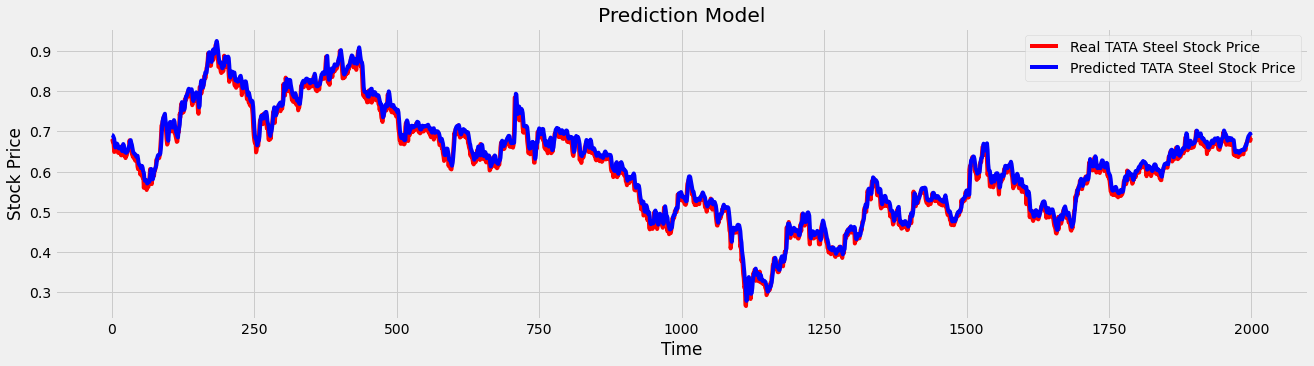

In [145]:
# VISUALIZATION OF PREDICTIONS VS REAL DATA
plt.figure(figsize=(20,5))
plt.plot(y_test,color="red",label="Real TATA Steel Stock Price")
plt.plot(pred,color="blue",label="Predicted TATA Steel Stock Price")
plt.title("Prediction Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()    
plt.show()

In [146]:
# CALCULATION OF RMSE VALUE
rmse = math.sqrt(mean_squared_error(y_test,pred))
print("rmse is:", '{0:.2f}'.format((rmse/1900)*100),"%")

rmse is: 0.00 %


In [147]:
predictions = [['Date','Predicted','Real']]
for i in range(len(pred)):
    predictions.append([test_dates[i][0], pred[i][0], y_test[i][0]])

In [148]:
predictions = pd.DataFrame(predictions)
predictions

,0,1,2
0,Date,Predicted,Real
1,2015-11-18,0.691609,0.675668
2,2015-11-19,0.691037,0.678122
3,2015-11-20,0.689231,0.672402
4,2015-11-23,0.685168,0.671046
...,...,...,...
1996,2023-09-07,0.688374,0.681662
1997,2023-09-08,0.690231,0.685857
1998,2023-09-11,0.692521,0.687427
1999,2023-09-12,0.694831,0.676613


# Step3: UNSUPERVISED LEARNING: *Prediction of Far Future*

In [149]:
# IMPORTING LIBRARIES
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [150]:
test_close = df.iloc[:, 3:4]
test_dates = df.iloc[:, 4:5]
dates = np.array(dates)
test_close = np.array(test_close)
test_close

array([[12549.8 ],
       [13147.35],
       [13752.95],
       ...,
       [19478.1 ],
       [19450.95],
       [19358.4 ]])

In [191]:
# PREDICTING STOCKS FROM start TO end INDICES in batches of 50 and considering previous 10 samples 
def new_predicting(test_close, start, end):
    im_test_close = [i[0] for i in test_close]

    # NORMALIZATION
    sc = MinMaxScaler()
    
    for i in range(start, end):
        new_test_close = sc.fit_transform(test_close)
        x_test = []

        # CREATING INPUT STREAM OF DATA
        x_test.append([new_test_close[i-500:i]])
        x_test_batch = np.reshape(x_test, (1, 500, 1))

        # PREDICTION
        pred = model.predict(x_test_batch)
        pred = sc.inverse_transform(pred)

        # UPDATING TESTSET WITH THE PREDICTED VALUE 
        im_test_close.append(pred[0][0])
        test_close = [[i] for i in im_test_close]
        print(len(test_close))
    return test_close

start = 5083
end = 5100
new = new_predicting(test_close, start, end)

1/1 [==============================] - 2s 2s/step
5084
1/1 [==============================] - 1s 941ms/step
5085
1/1 [==============================] - 1s 912ms/step
5086
1/1 [==============================] - 1s 903ms/step
5087
1/1 [==============================] - 1s 900ms/step
5088
1/1 [==============================] - 1s 876ms/step
5089
1/1 [==============================] - 1s 908ms/step
5090
1/1 [==============================] - 1s 958ms/step
5091
1/1 [==============================] - 1s 913ms/step
5092
1/1 [==============================] - 1s 924ms/step
5093
1/1 [==============================] - 1s 917ms/step
5094
1/1 [==============================] - 1s 988ms/step
5095
1/1 [==============================] - 1s 916ms/step
5096
1/1 [==============================] - 1s 913ms/step
5097
1/1 [==============================] - 1s 988ms/step
5098
1/1 [==============================] - 1s 932ms/step
5099
1/1 [==============================] - 1s 963ms/step
5100


In [40]:
# DATA PREPROCESSING AND CLEANING
test_set = df
test_open = test_set.iloc[:,3:4].values #close prices
test_dates = test_set.iloc[:,4:5].values #dates
print(len(test_dates))

5083


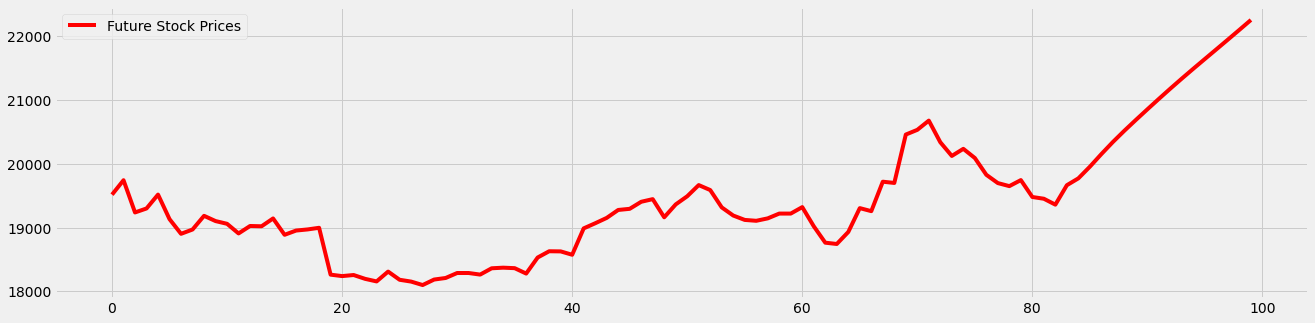

In [192]:
plt.figure(figsize=(20,5))
plt.plot(new[5000:5100],color="red",label="Future Stock Prices")
plt.legend()
plt.show()

In [193]:
new[5082:5100]

[[19358.4],
 [19662.64],
 [19770.191],
 [19952.55],
 [20150.188],
 [20339.127],
 [20515.928],
 [20685.096],
 [20850.92],
 [21014.746],
 [21175.861],
 [21333.426],
 [21487.598],
 [21639.543],
 [21790.783],
 [21942.559],
 [22095.58],
 [22250.05]]

In [189]:
test_close[-1]

array([19358.4])